In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import muon as mu
# Import a module with ATAC-seq-related functions
from muon import atac as ac

from matplotlib import pyplot as plt
import seaborn as sns

sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)

from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"

/home/chaozhong/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### scRNA-seq preprocessing

In [2]:
rna = ad.read_h5ad('data/h5ad/HSPC_Multiome_RNA.h5ad')
rna.obs['donor'] = rna.obs['donor'].astype('category')
subset_cells = np.random.choice(rna.obs_names, size=15000, replace=False)
rna = rna[subset_cells,:]
rna

View of AnnData object with n_obs × n_vars = 15000 × 23418
    obs: 'cell_id', 'day', 'donor', 'cell_type', 'index_col'

In [3]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # the data has already been preprocessed, no need to run
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/tmp/ipykernel_1955761/3273425670.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


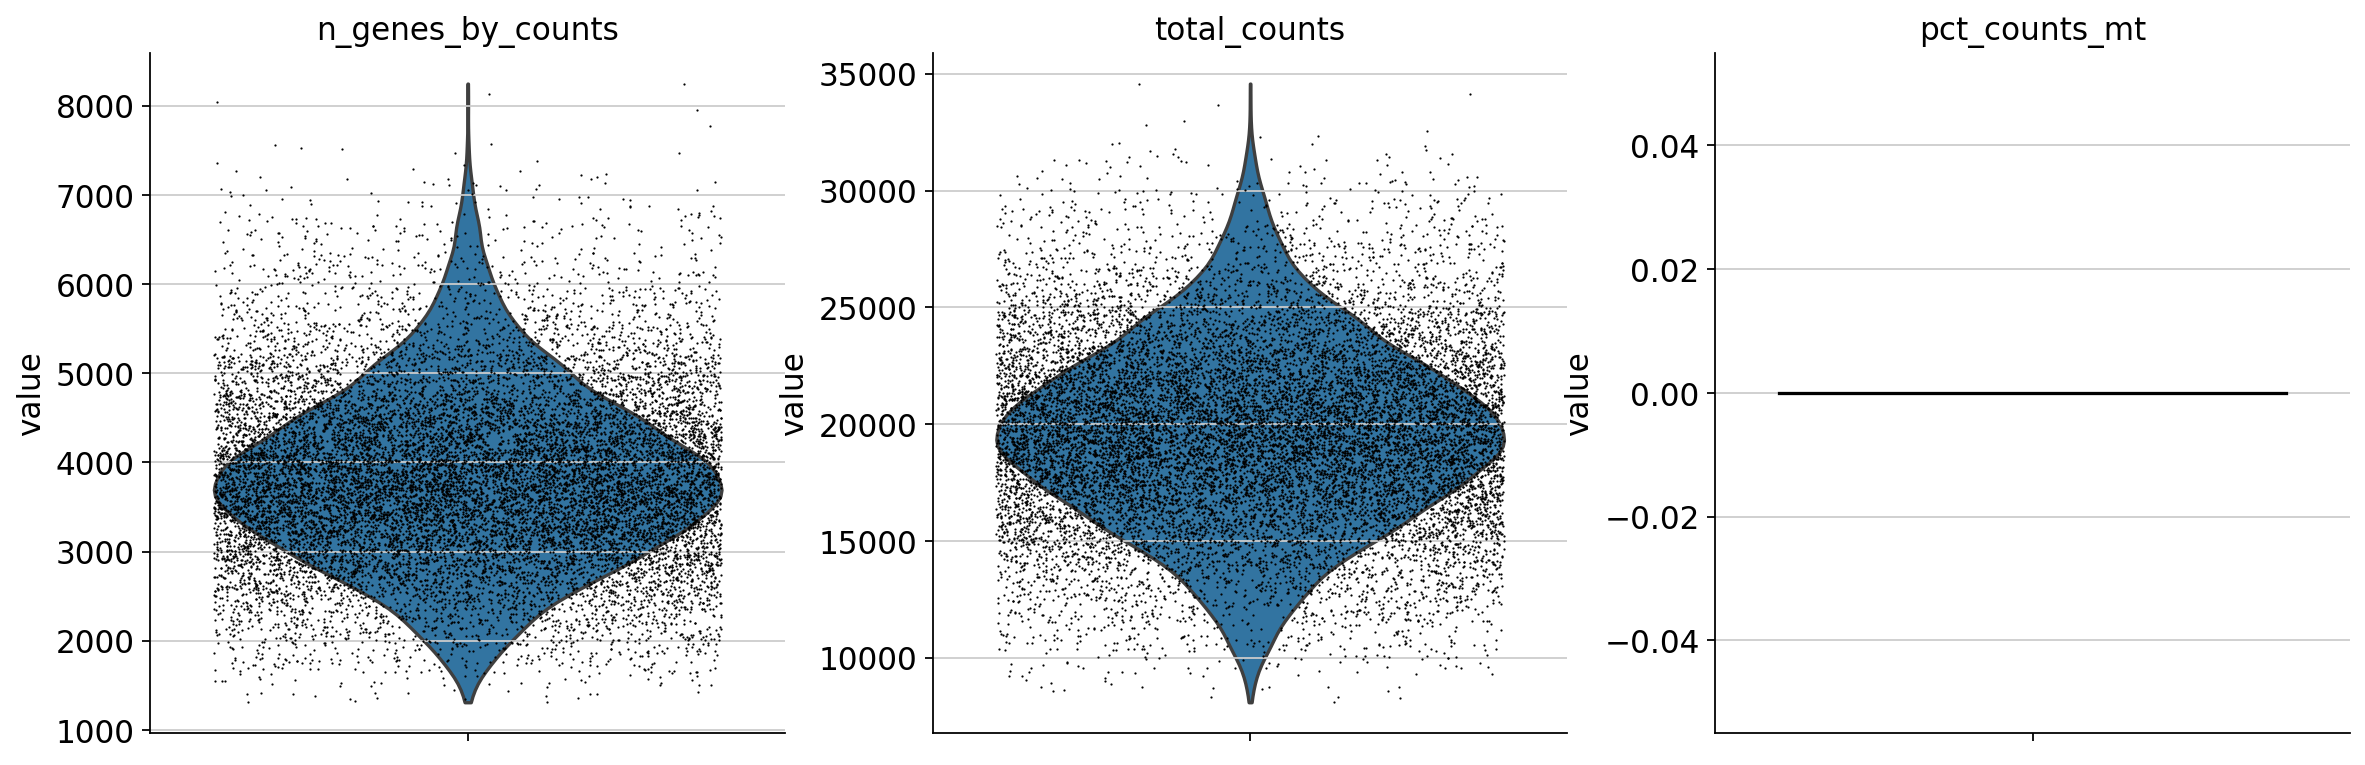

In [4]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [5]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 15)

In [7]:
# remove BP, because it has only few cells
rna = rna[rna.obs['cell_type']!='BP'].copy()
rna

AnnData object with n_obs × n_vars = 14927 × 21121
    obs: 'cell_id', 'day', 'donor', 'cell_type', 'index_col', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

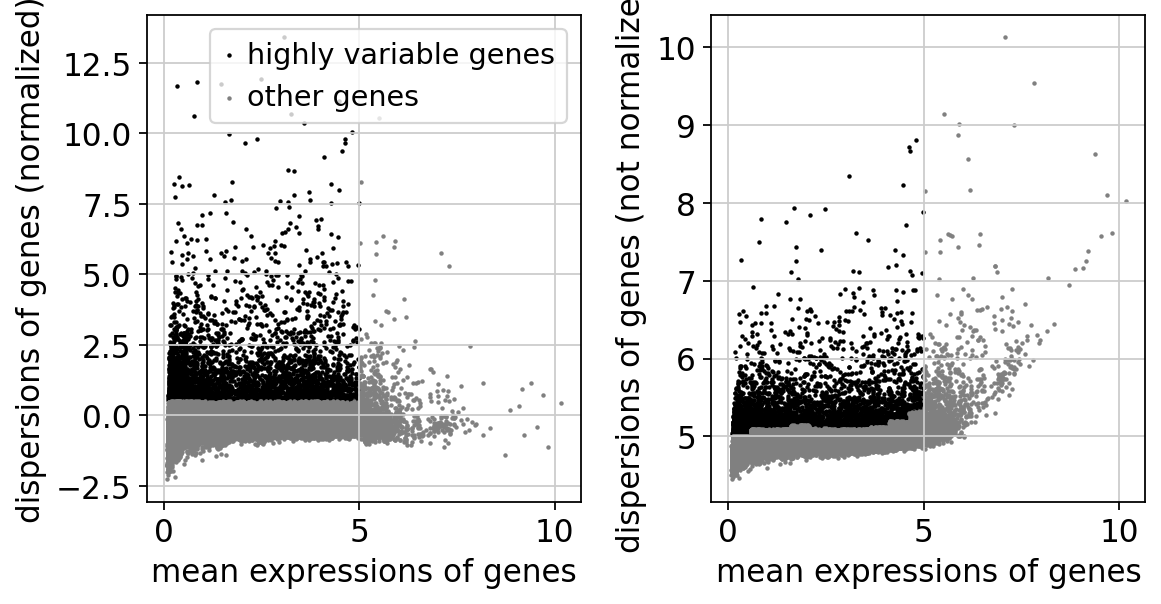

In [8]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=5.0, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


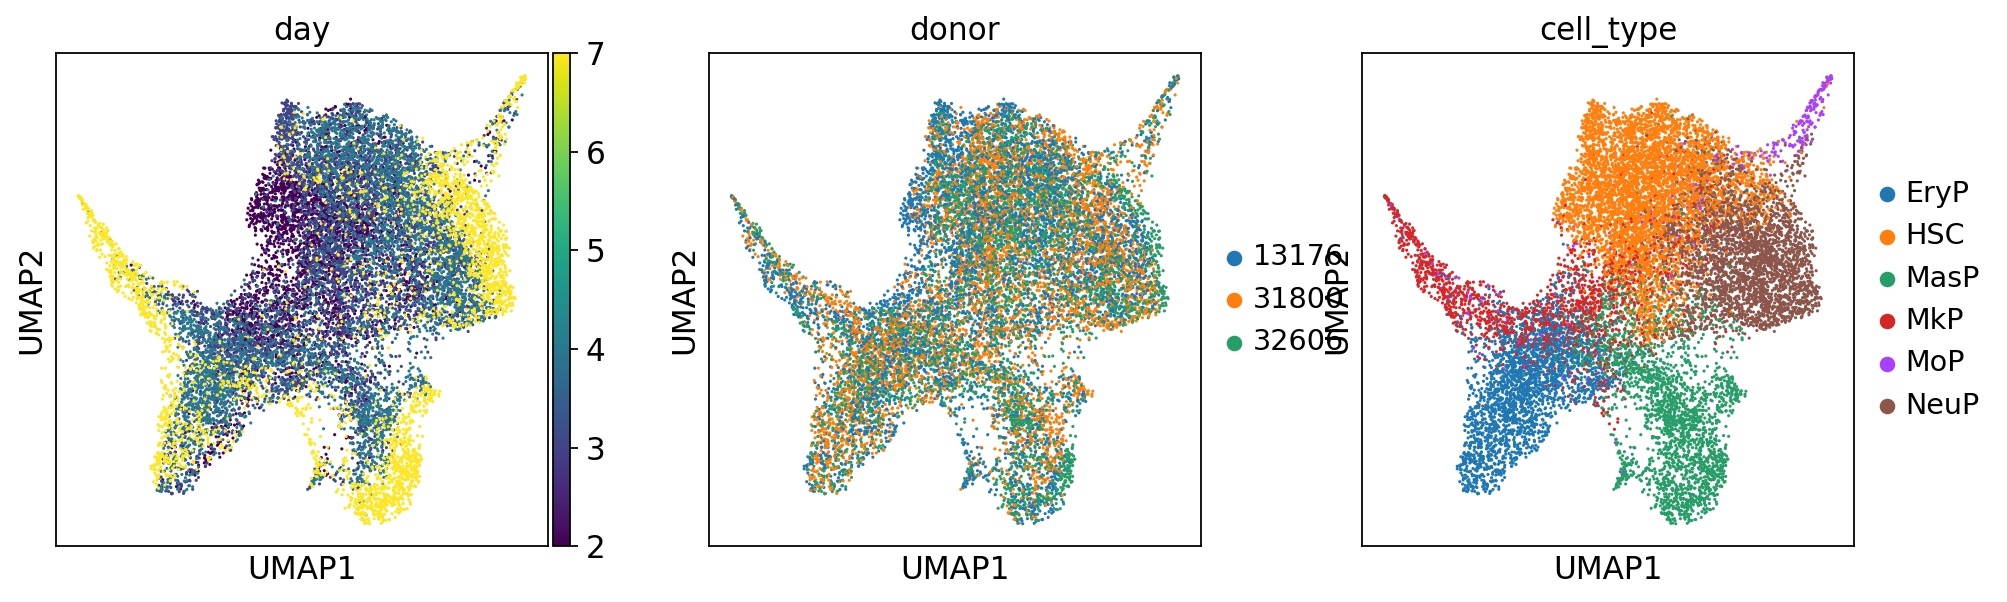

In [9]:
rna.raw = rna.copy()
# The data has already been log-transformed
sc.pp.scale(rna, max_value=10)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=20, n_pcs=30)
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color=["day","donor","cell_type"])

In [10]:
rna.X = rna.raw.X
rna.write_h5ad('data/muon_out/HSPC_Muon_RNA.h5ad')

### scATAC-seq preprocessing

In [11]:
atac = ad.read_h5ad('data/h5ad/HSPC_Multiome_ATAC.h5ad')
atac.obs['donor'] = atac.obs['donor'].astype('category')
atac = atac[subset_cells,:]
atac

View of AnnData object with n_obs × n_vars = 15000 × 228942
    obs: 'cell_id', 'day', 'donor', 'cell_type', 'index_col'

/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


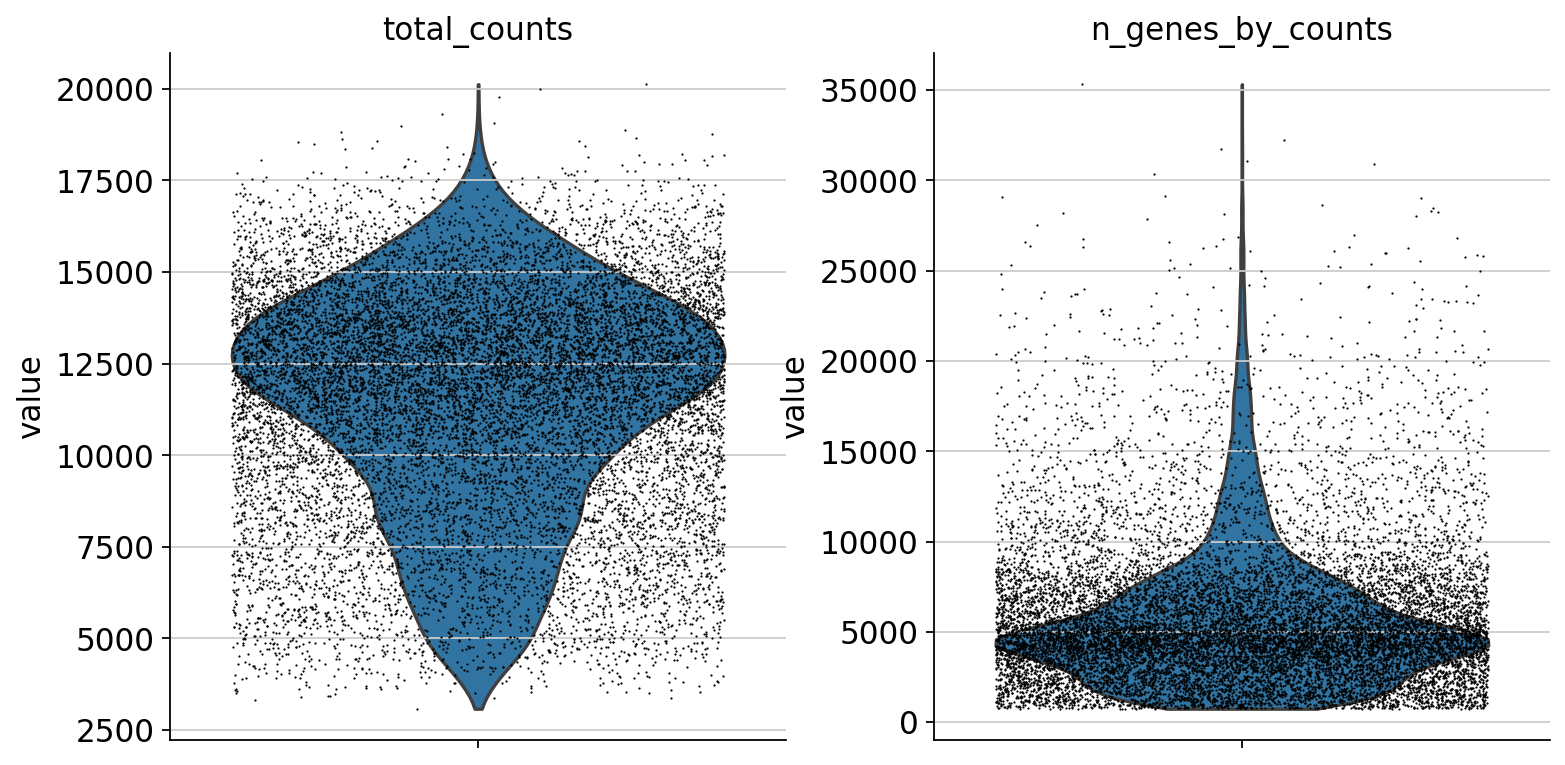

In [12]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)


In [14]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# remove BP
atac = atac[atac.obs['cell_type']!='BP'].copy()
atac

AnnData object with n_obs × n_vars = 14927 × 228674
    obs: 'cell_id', 'day', 'donor', 'cell_type', 'index_col', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


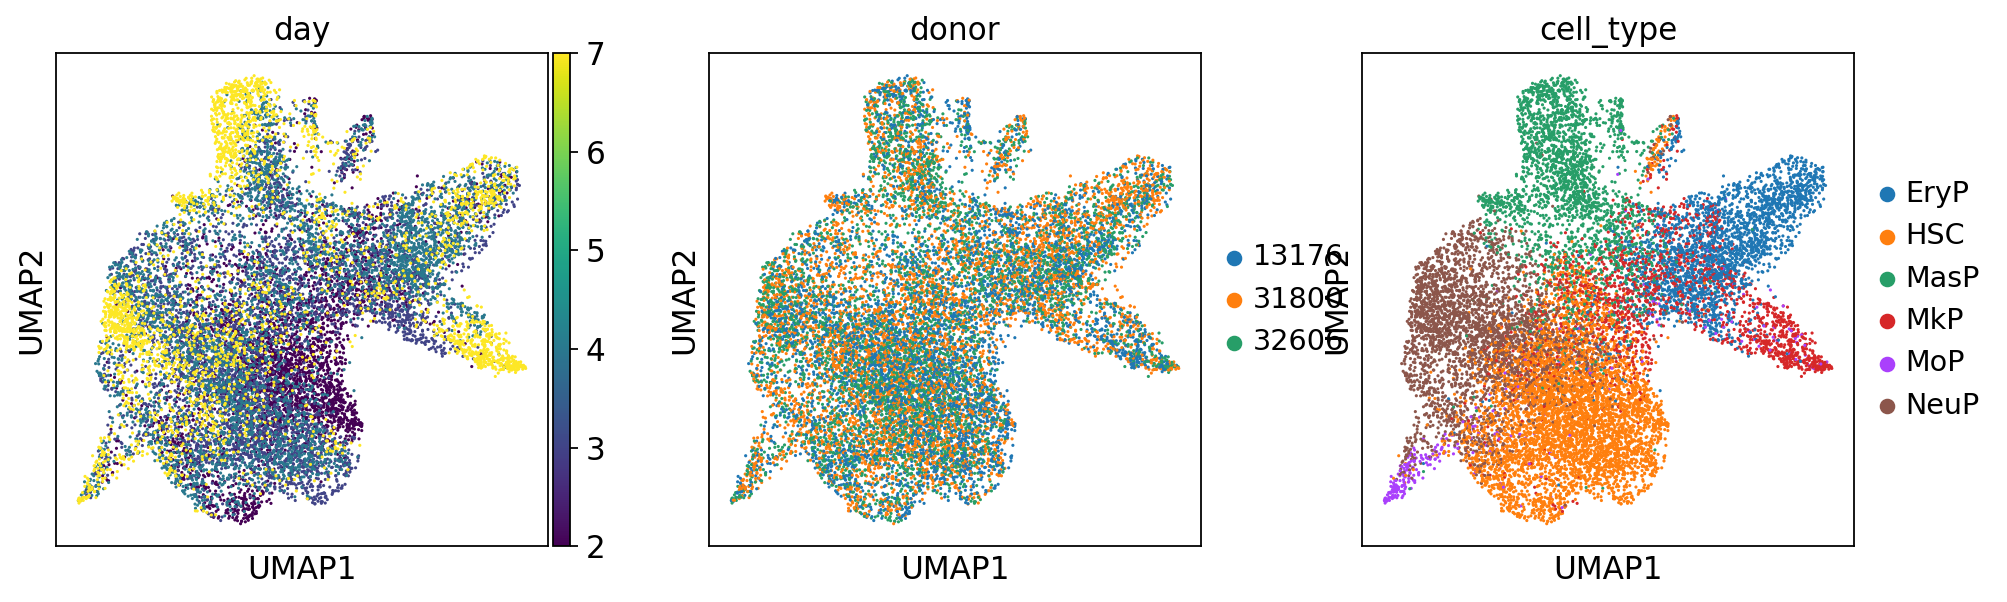

In [15]:
atac.raw = atac
ac.tl.lsi(atac)
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)
sc.pl.umap(atac, color=["day","donor","cell_type"]) #, legend_loc="on data")

In [16]:
atac.write_h5ad('data/muon_out/HSPC_Muon_ATAC.h5ad')

### Integration

In [2]:
rna = ad.read_h5ad('data/muon_out/HSPC_Muon_RNA.h5ad')
atac = ad.read_h5ad('data/muon_out/HSPC_Muon_ATAC.h5ad')
mdata = mu.MuData({"rna": rna, "atac": atac})
mu.pp.intersect_obs(mdata)
mdata.shape

(14927, 249795)

In [3]:
# Set color palette for days
mdata.obs['day'] = mdata.obs['rna:day'].astype('category')
day_color = ['#fafcd0', '#d6ebb9', '#8bc7bc', '#253188']
mdata.uns['day_colors'] = day_color

*Need to compare how the number of neighbors will influence the correlation results
- General trend
- Results more sparse
- Not affecting results much

#### n_neighbors = 20

/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


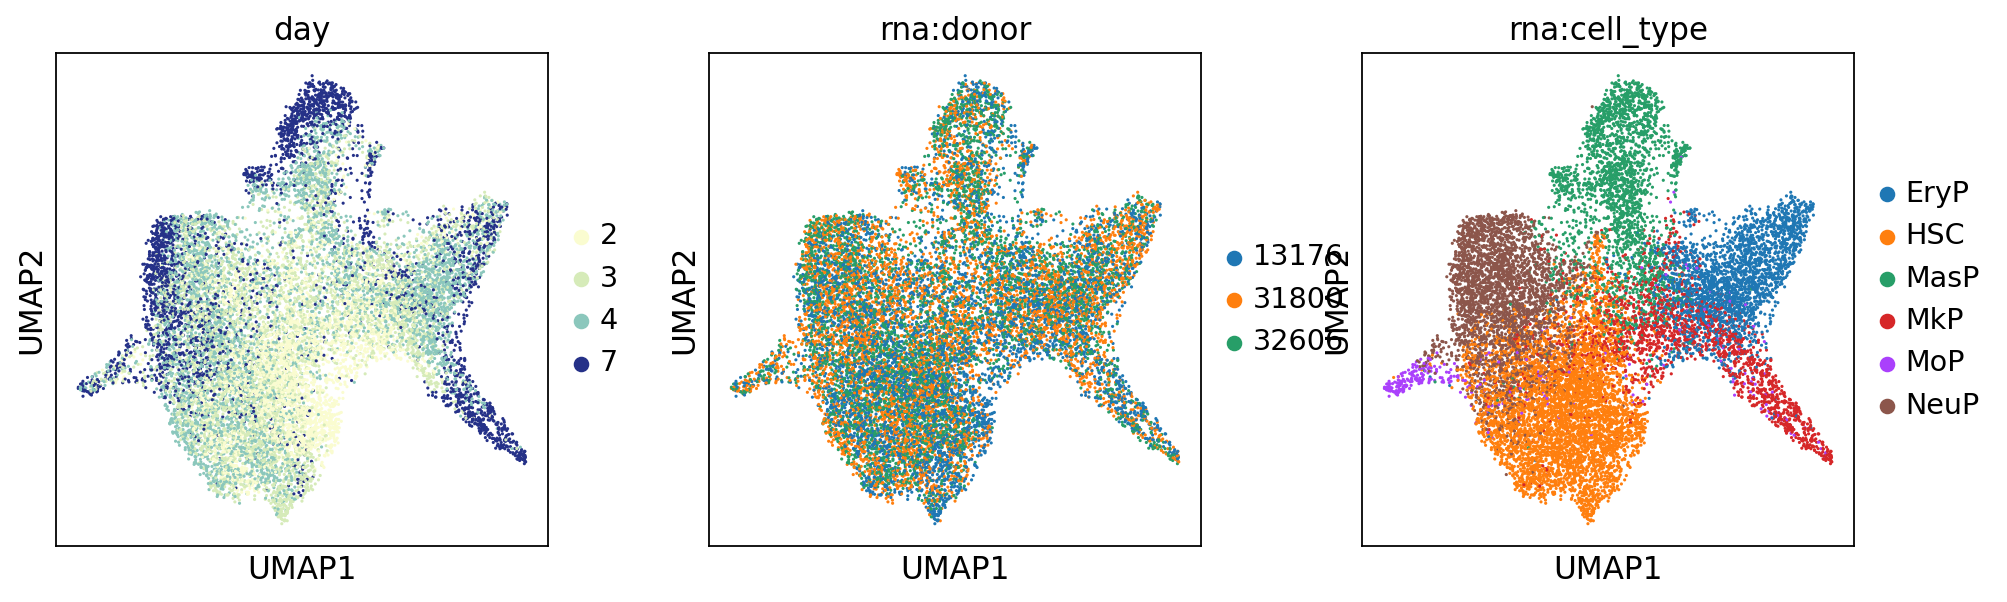

In [4]:
mu.pp.neighbors(mdata,n_neighbors=20)
mu.tl.umap(mdata)

mdata.mod['rna'].obs['donor'] = mdata.mod['rna'].obs['donor'].astype('category')
sc.pl.umap(mdata, color=["day","rna:donor","rna:cell_type"])


#### Re-annotation

/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


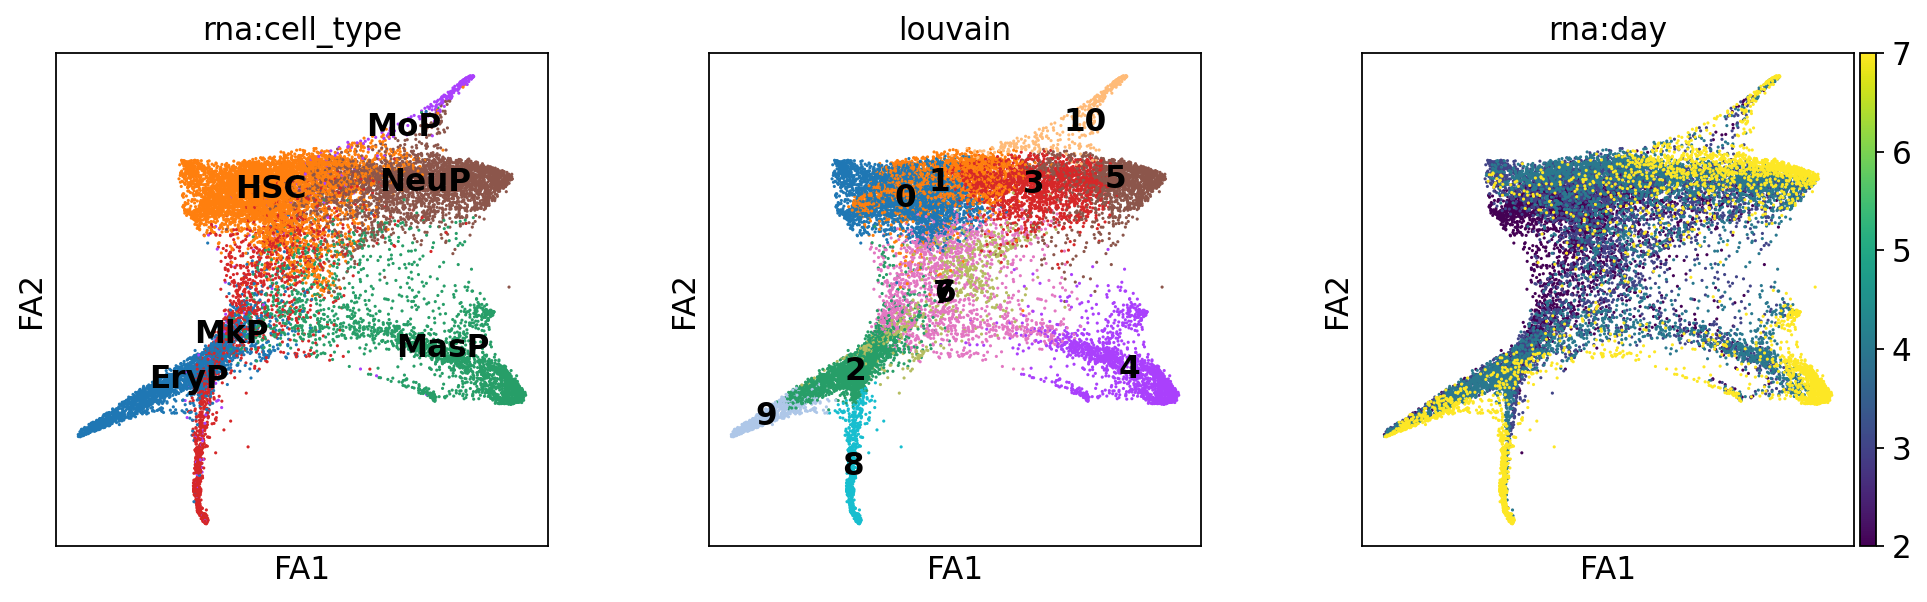

In [5]:
sc.tl.draw_graph(mdata)
sc.tl.louvain(mdata, resolution=1.0)
mdata.obs['louvain_1.0'] = mdata.obs['louvain'].copy()
sc.pl.draw_graph(mdata,
                 color=["rna:cell_type","louvain","rna:day"], 
                 legend_loc='on data')

/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


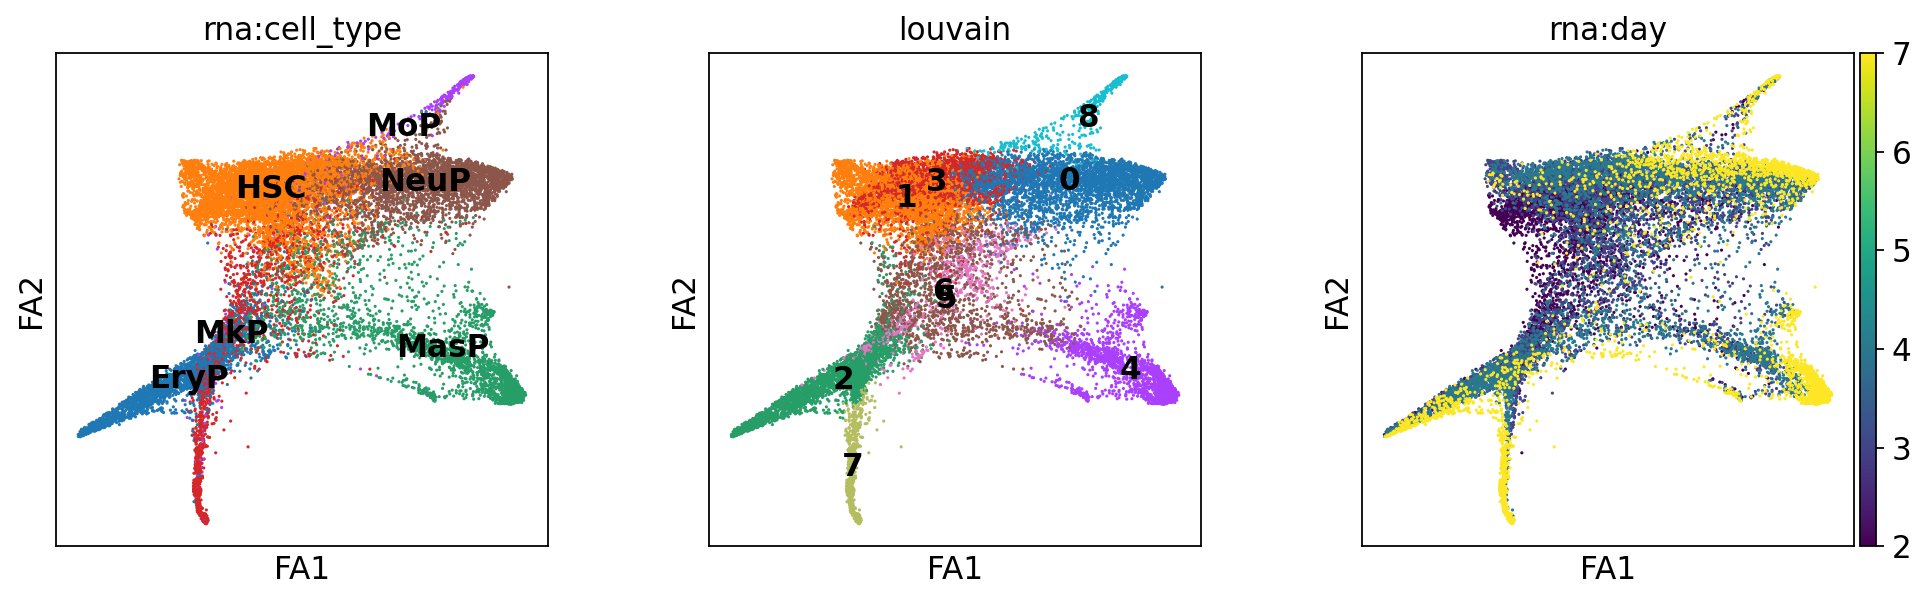

In [6]:
sc.tl.louvain(mdata, resolution=0.75)
sc.pl.draw_graph(mdata,
                 color=["rna:cell_type","louvain","rna:day"], 
                 legend_loc='on data')

In [7]:
# Manually annotation
mdata.obs['annotation'] = 'None'
mdata.obs.loc[mdata.obs['louvain']=='1', 'annotation'] = 'HSC'
mdata.obs.loc[mdata.obs['louvain_1.0']=='1', 'annotation'] = 'HSC'
mdata.obs.loc[mdata.obs['rna:cell_type']=='MoP', 'annotation'] = 'MoP'
mdata.obs.loc[(mdata.obs['louvain']=='0') & (mdata.obs['rna:cell_type']=='NeuP'), 'annotation'] = 'NeuP'
mdata.obs.loc[(mdata.obs['louvain']=='0') & (mdata.obs['rna:cell_type']!='NeuP'), 'annotation'] = '2'
mdata.obs.loc[mdata.obs['louvain_1.0']=='3', 'annotation'] = '2'
mdata.obs.loc[mdata.obs['louvain']=='5', 'annotation'] = '5'
mdata.obs.loc[mdata.obs['louvain']=='6', 'annotation'] = '5'
mdata.obs.loc[mdata.obs['louvain']=='4', 'annotation'] = 'MasP'
mdata.obs.loc[mdata.obs['louvain_1.0']=='2', 'annotation'] = '7'
mdata.obs.loc[mdata.obs['louvain_1.0']=='8', 'annotation'] = 'MkP'
mdata.obs.loc[mdata.obs['louvain_1.0']=='9', 'annotation'] = 'EryP'
mdata.obs.loc[(mdata.obs['annotation']=='None') & (mdata.obs['louvain'].isin(['0','1','3','8'])), 'annotation'] = '2'
mdata.obs.loc[(mdata.obs['annotation']=='None'), 'annotation'] = '5'

mdata.obs['annotation'].unique()

# Annotation Color
mdata.obs["annotation"] = mdata.obs["annotation"].astype('category')
mdata.obs["annotation"] = mdata.obs["annotation"].cat.set_categories(["HSC", "2", "MoP", "NeuP", "5", "MasP", "7", "EryP", "MkP"], ordered=True)
mdata.uns["annotation_colors"] = np.array(sc.pl.palettes.zeileis_28)[[12, 8, 0, 6, 21, 18, 9, 5, 17]].tolist()


/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


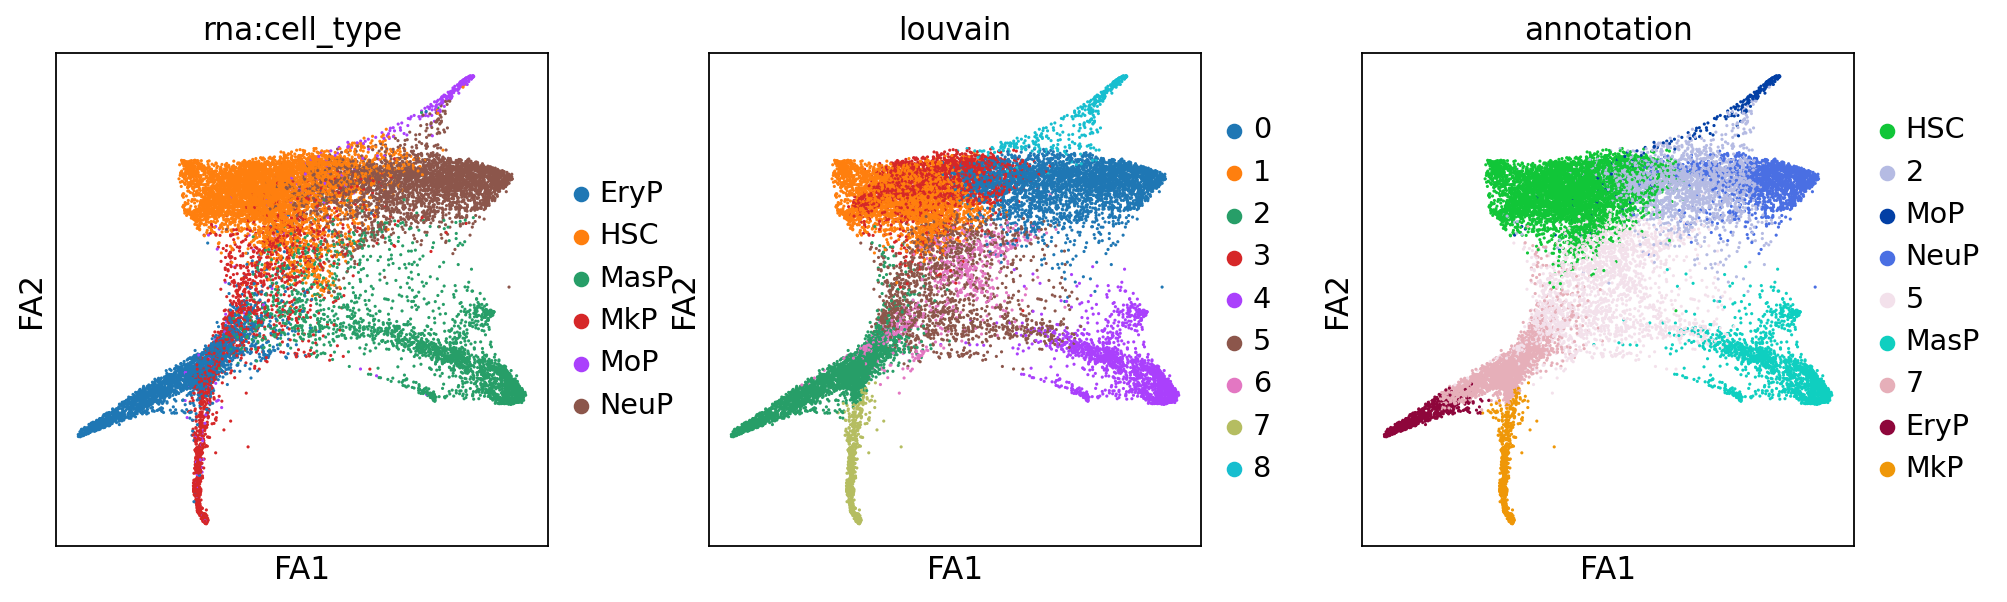

In [8]:
sc.pl.draw_graph(mdata,
                 color=["rna:cell_type","louvain","annotation"])

In [11]:
sc.tl.paga(mdata, groups='annotation')
sc.pl.paga(mdata, threshold=0.05, show=False, save='hspc_paga.pdf')

<Axes: >

In [12]:
sc.tl.draw_graph(mdata, init_pos='paga')
mdata.uns['iroot'] = np.flatnonzero(mdata.obs['annotation']  == 'HSC')[0]
sc.tl.dpt(mdata)


/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chaozhong/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


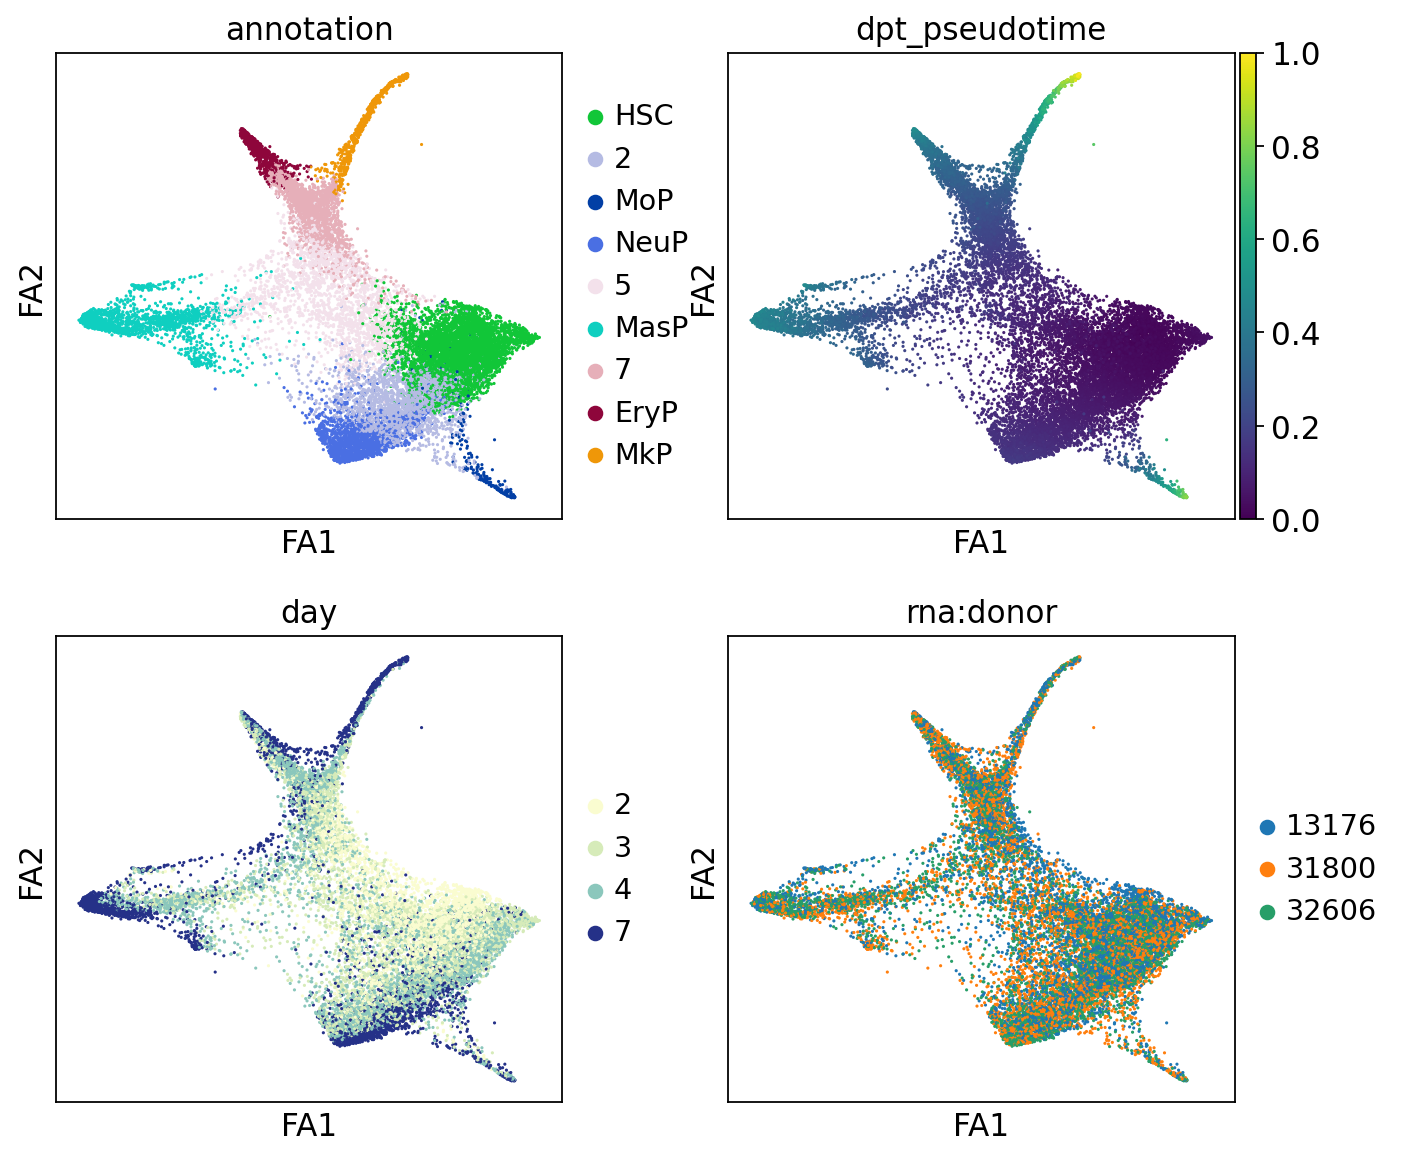

In [14]:
sc.pl.draw_graph(mdata, color=['annotation', 'dpt_pseudotime', 'day', 'rna:donor'],
                 ncols=2, save='hspc_fa_colors.pdf')

In [15]:
mdata.write("data/muon_out/HSPC_Muon_processed.h5mu")